# Previsão de Doenças Hepáticas

Este mini-projeto tem como objetivo, construir um modelo de Machine Learning capaz de prever se um paciente vai ou não, desenvolver uma doença hepática com base em diversas características do paciente. Este modelo pode ajudar médicos, hospitais ou governos a planejar melhor o orçamento de gastos de saúde ou mesmo criar políticas de prevenção.

In [162]:
#imports

import joblib #para salvar modelos em disco
import pickle #para salvar modelos em disco
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV #Otimização de hiperparâmetros
from sklearn.model_selection import cross_val_score #validação cruzada
from sklearn.model_selection import RandomizedSearchCV #Otmizaçao de hiperparâmetros
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## **1- Importando a Base de Dados**

Os dados que vamos trabalhar neste estudo, foram coletados no nordeste de Andhra Pradesh, na Índia. Contém 416 registros de pacientes hepáticos e 167 registros de pacientes não hepáticos.

In [163]:
dados = pd.read_csv('dados/dataset.csv')

In [164]:
# Shape
dados.shape

(583, 11)

Temos 583 linhas (pacientes) e 11 colunas (variáveis).

In [165]:
# Variáveis
dados.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

Informações das Variáveis:

1. Age of the patient
2. Gender of the patient
3. otal Bilirubin
4. Direct Bilirubin
5. Alkaline Phosphotase
6. Alamine Aminotransferase
7. Aspartate Aminotransferase
8. Total Protiens
9. Albumin
10. Albumin and Globulin Ratio
11. Dataset: variável que rotula os pacientes como hepáticos ou não (rotulado pelos especialistas).

In [166]:
# Amostra dos dados
dados.sample(10)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
405,31,Female,0.8,0.2,215,15,21,7.6,4.0,1.10,1
83,33,Male,2.0,1.0,258,194,152,5.4,3.0,1.25,1
258,36,Male,0.8,0.2,182,31,34,6.4,3.8,1.40,2
84,32,Male,0.6,0.1,237,45,31,7.5,4.3,1.34,1
231,61,Male,0.8,0.1,282,85,231,8.5,4.3,1.00,1
459,65,Male,1.1,0.5,686,16,46,5.7,1.5,0.35,1
289,57,Male,4.5,2.3,315,120,105,7.0,4.0,1.30,1
223,50,Male,1.1,0.3,175,20,19,7.1,4.5,1.70,2
64,57,Male,1.3,0.4,259,40,86,6.5,2.5,0.60,1
466,28,Female,0.6,0.1,137,22,16,4.9,1.9,0.60,2


Inicialmente, podemos observar que temos apenas uma variávei categórica, que é o 'Gender' do paciente. A variávei target tem como título 'Dataset'.

## **2- Análise Exploratória dos Dados**

In [167]:
dados.dtypes

Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

In [168]:
# Variáveis categóricas
dados.dtypes[dados.dtypes == 'object']

Gender    object
dtype: object

In [169]:
# Variáveis não categóricas
dados.dtypes[dados.dtypes != 'object']

Age                             int64
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

**Explorando as Variáveis Numéricas**

In [170]:
dados.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


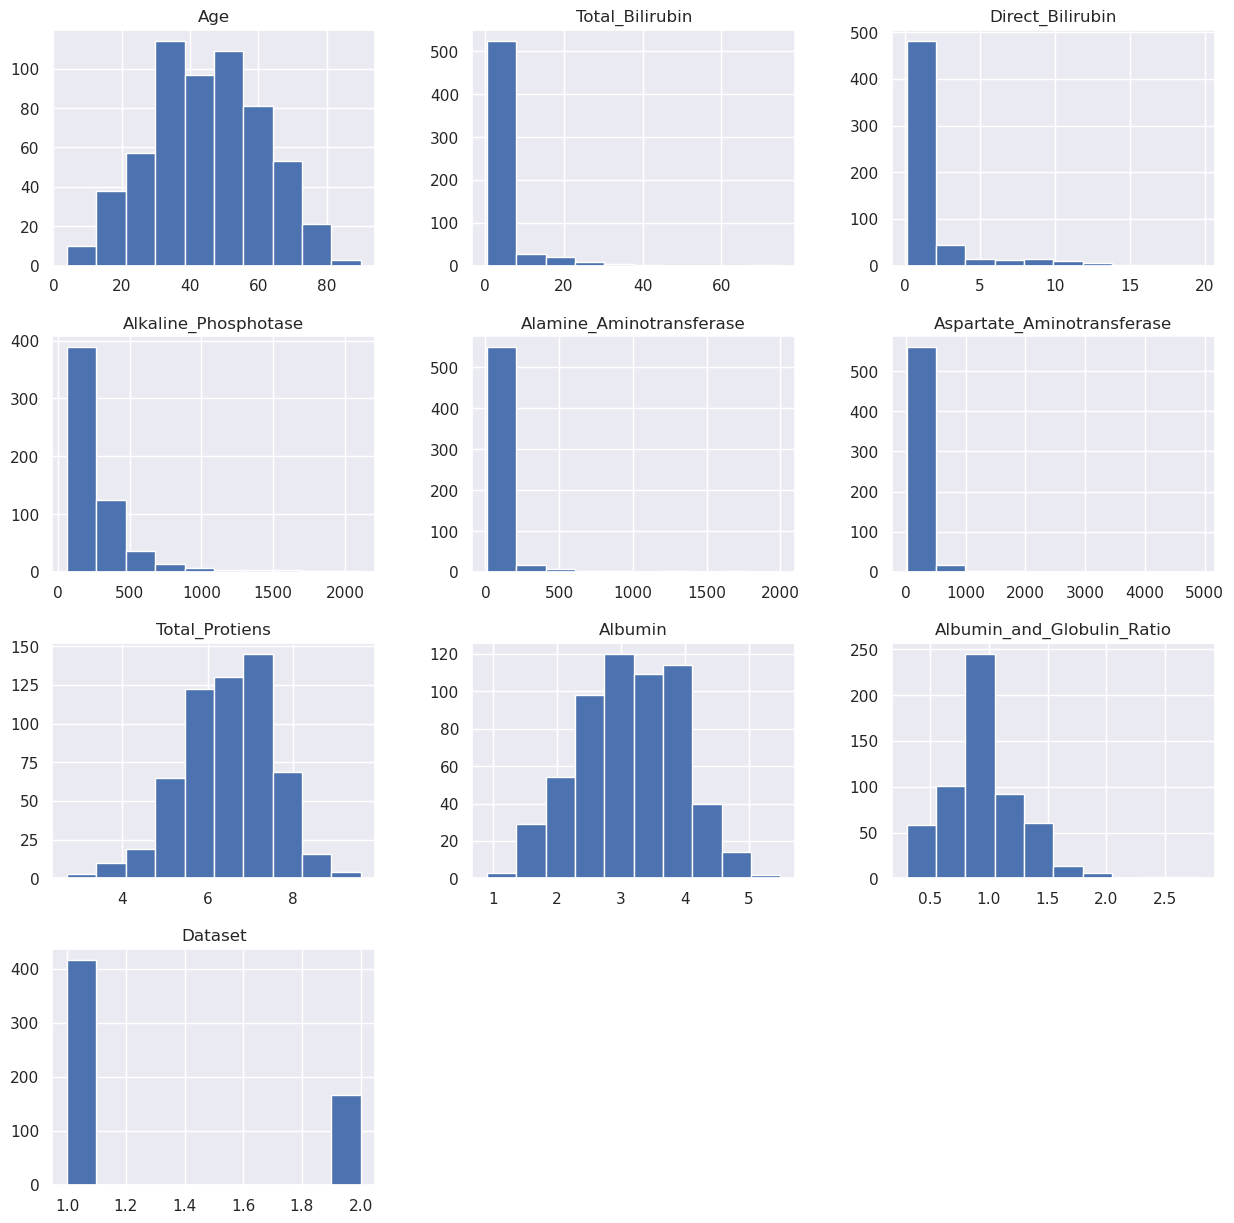

In [171]:
dados.hist(figsize= (15,15), bins=10)
plt.show()

Podemos observar nos gráficos acima, que as variáveis Age, Total_Proteins e Albumin, aparentemente seguem uma distribuição normal ou bem próximo de uma normal. Além disso, podemos observar também, analisando os gráficos em conjunto com o "describe" anterior, que parece haver outliers nas variáveis **Alamine_Aminotransferase** e **Aspartate_Aminotransferase**, pois o valor máximo é muito maior que a média da variável!

A variável Dataset, tem '1' para doença hepática e '2' para nenhuma doença hepática. Vamos ajustar a variável para valores mais fáceis de interpretar. Vamos ajustar para '1' possui doença hepática e '0' não possui doença hepática:

In [172]:
def ajustar_dataset(x):
    if x == 2:
        return 0
    return 1

In [173]:
#Aplicando a função
dados['Dataset'] = dados['Dataset'].map(ajustar_dataset)

In [174]:
#Ajustando o nome da variável target
dados.rename({'Dataset' : 'Target'}, axis='columns', inplace=True)

In [175]:
dados.head(1)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,1


Vamos observar a correlação entre as variáveis:

In [176]:
dados.corr()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
Age,1.000000,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216408,0.137351
Total_Bilirubin,0.011763,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206267,0.220208
Direct_Bilirubin,0.007529,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200125,0.246046
Alkaline_Phosphotase,0.080425,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.234166,0.184866
Alamine_Aminotransferase,-0.086883,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002375,0.163416
Aspartate_Aminotransferase,-0.019910,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070040,0.151934
Total_Protiens,-0.187461,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.234887,-0.035008
Albumin,-0.265924,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.689632,-0.161388
Albumin_and_Globulin_Ratio,-0.216408,-0.206267,-0.200125,-0.234166,-0.002375,-0.070040,0.234887,0.689632,1.000000,-0.163131
Target,0.137351,0.220208,0.246046,0.184866,0.163416,0.151934,-0.035008,-0.161388,-0.163131,1.000000


<Axes: >

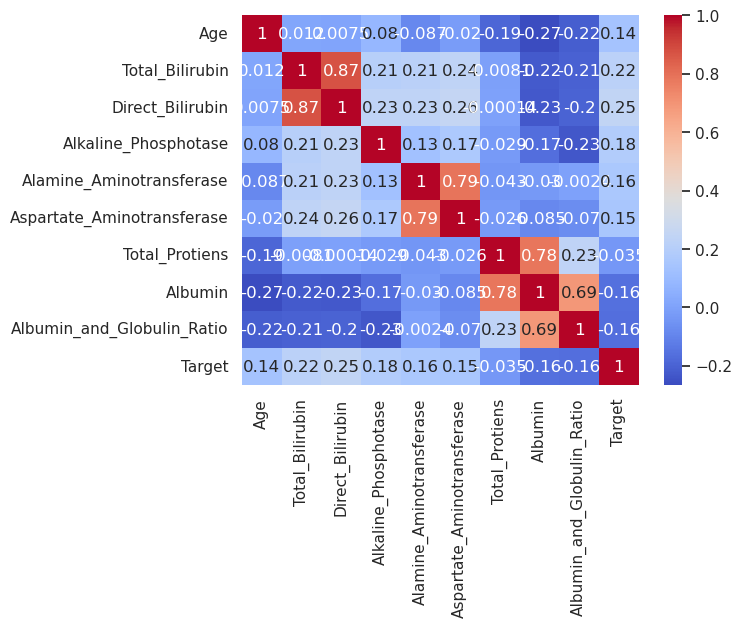

In [177]:
#Analisando graficamente:

matriz_corr = dados.corr()
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm')

Podemos observar, que não parece haver correlação entre a idade do paciente com as características que indicam a doença hepática. Também podemos observar uma alta correlação positiva entre Total_Bilirubin e Direct_Bilirubin, isto pode ser um problema para treinar nosso modelo de machine learning (problema de multicolinearidade).

**Exploração da Variável Categórica**

In [178]:
dados.describe(include=['object'])

,Gender
count,583
unique,2
top,Male
freq,441


O que temos acima, significa o seguinte: temos 583 registros divididos entre duas classes ('Male' e 'Female'); top que mostra a classe com mais ocorrências no dataset.

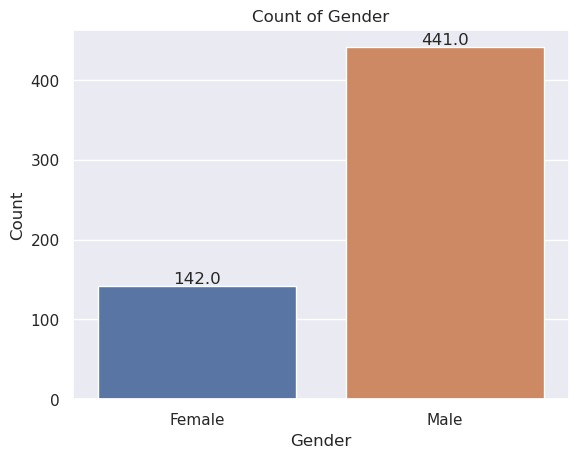

In [179]:
sns.set(style="darkgrid")

# Plot
ax = sns.countplot(data=dados, x='Gender', label='Count')

# Value counts
M, F = dados['Gender'].value_counts()

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Gender')
plt.show()

Temos que mais dados sobre pacientes do sexo masculino; o ideal, seriam dados bastante proporcionais entre os sexos. Deste forma, o modelo que será construído irá aprender bem as características de doençã hepática ou não, do sexo masculino; talvez não aprenda tão bem para o sexo feminino. Vale ressaltar, que não faz sentido balanceamento pois esta não é classe que queremos prever!

Já vamos transformar a variável categórica em sua representação numérica, usando label encoding. Além de reduzir o trabalho mais tarde, também facilitará a criação de gráficos durante o estudo.

In [180]:
# Função para label encondig
def encoding_func(x):
    if x == 'Male':
        return 0
    return 1

In [181]:
# Aplicando a função à esta variável
dados['Gender'] = dados['Gender'].map(encoding_func)

In [182]:
dados.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
393,41,0,2.7,1.3,580,142,68,8.0,4.0,1.0,1
420,55,1,10.9,5.1,1350,48,57,6.4,2.3,0.5,1
564,38,1,0.6,0.1,165,22,34,5.9,2.9,0.9,0
543,40,0,1.2,0.6,204,23,27,7.6,4.0,1.1,1
579,40,0,0.6,0.1,98,35,31,6.0,3.2,1.1,1


**Verificando a Relação Entre Atributos**

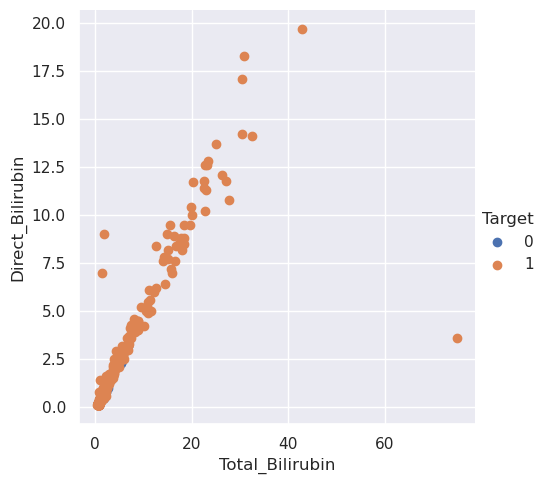

In [183]:
sns.set_style('darkgrid')

sns.FacetGrid(dados, hue = 'Target', height=5).map(plt.scatter, 'Total_Bilirubin', 'Direct_Bilirubin').add_legend()

Esses dois atributos, tem uma alta correlação com a detecção da doença. Provavelmente, uma das duas poderá ser removida do conjunto de dados, pois a multicolinearidade poderá fazer com que o modelo de machine learning fique tedencioso!

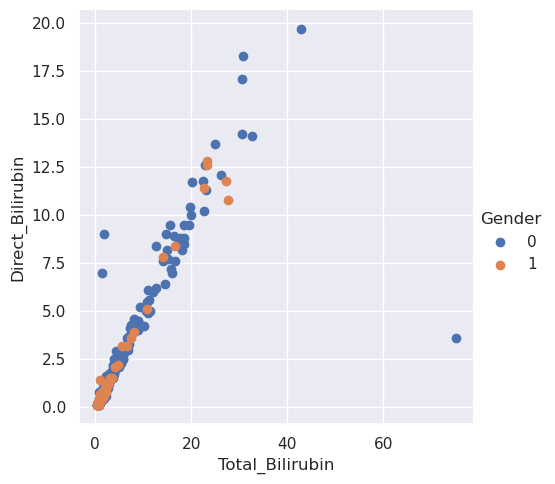

In [184]:
sns.set_style('darkgrid')

sns.FacetGrid(dados, hue = 'Gender', height=5).map(plt.scatter, 'Total_Bilirubin', 'Direct_Bilirubin').add_legend()

Podemos observar que o sexo do paciente não parece ter uma relação direta com essas duas variáveis, o que comprova que uma delas poderá ser removida do conjunto de dados!

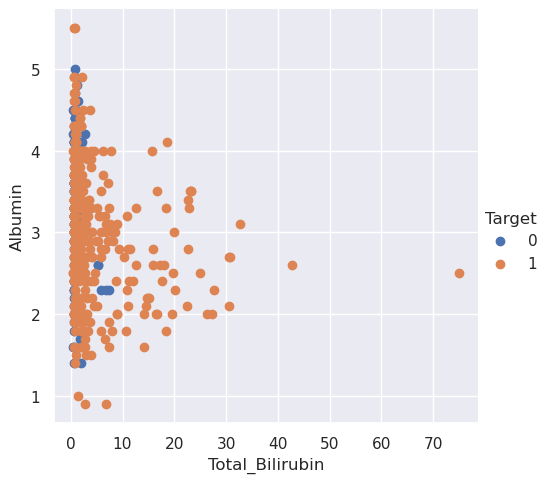

In [185]:
sns.set_style('darkgrid')

sns.FacetGrid(dados, hue = 'Target', height=5).map(plt.scatter, 'Total_Bilirubin', 'Albumin').add_legend()

Temos um padrão mas não parece haver uma correlação entre as duas variáveis numéricas e à variável alvo.

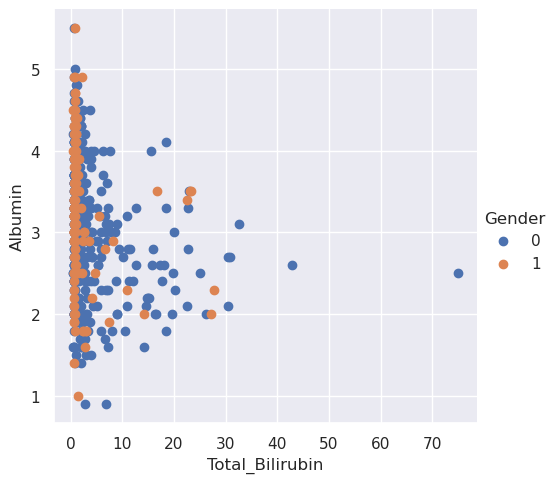

In [186]:
sns.set_style('darkgrid')

sns.FacetGrid(dados, hue = 'Gender', height=5).map(plt.scatter, 'Total_Bilirubin', 'Albumin').add_legend()

Essas duas variáveis poderão ser mantidas no conjunto de dados.

**Verificando Valores Ausentes e Registros Duplicados**

In [187]:
dados[dados.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
209,45,1,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,0,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,1,0.6,0.2,180,12,15,5.2,2.7,NaN,0
312,27,0,1.3,0.6,106,25,54,8.5,4.8,NaN,0


**Verificando Registros Duplicados**

In [188]:
dados[dados.duplicated(keep=False)]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
18,40,1,0.9,0.3,293,232,245,6.8,3.1,0.80,1
19,40,1,0.9,0.3,293,232,245,6.8,3.1,0.80,1
25,34,0,4.1,2.0,289,875,731,5.0,2.7,1.10,1
26,34,0,4.1,2.0,289,875,731,5.0,2.7,1.10,1
33,38,1,2.6,1.2,410,59,57,5.6,3.0,0.80,0
34,38,1,2.6,1.2,410,59,57,5.6,3.0,0.80,0
54,42,0,8.9,4.5,272,31,61,5.8,2.0,0.50,1
55,42,0,8.9,4.5,272,31,61,5.8,2.0,0.50,1
61,58,0,1.0,0.5,158,37,43,7.2,3.6,1.00,1
62,58,0,1.0,0.5,158,37,43,7.2,3.6,1.00,1


## **3- Limpeza dos Dados**

**Removendo registros duplicados**

In [189]:
dados = dados.drop_duplicates()

**Tratamento de Outliers**

In [190]:
dados.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,566.000000,570.000000
mean,44.849123,0.245614,3.321754,1.497544,291.750877,79.728070,109.380702,6.496316,3.148947,0.948004,0.712281
std,16.242182,0.430829,6.267941,2.833231,245.291859,181.471697,290.880671,1.088300,0.796813,0.319635,0.453097
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.000000,0.800000,0.200000,176.000000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,0.000000,1.000000,0.300000,208.000000,35.000000,41.000000,6.600000,3.100000,0.950000,1.000000
75%,58.000000,0.000000,2.600000,1.300000,298.000000,60.000000,86.750000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000


A partir do *describe()* no nosso dataset, observamos que as variáveis "Alamine_Aminotransferase" e "Aspartate_Aminotransferase" possuem valores máximos muito acima da média. Portanto, vale verificar de fato, se vamos considerar esses valores como outliers ou não.

<Axes: >

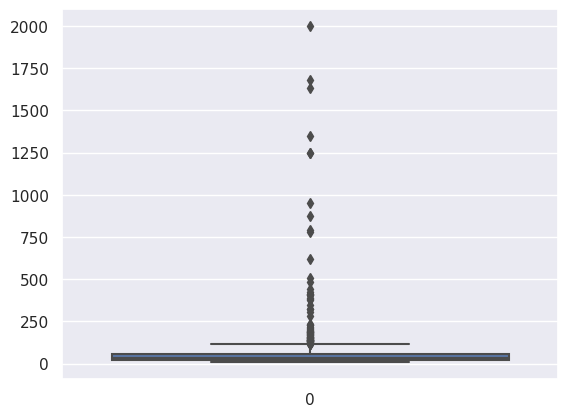

In [191]:
sns.boxplot(dados.Alamine_Aminotransferase)

In [192]:
#Contaegem de frequência por valor
dados.Alamine_Aminotransferase.sort_values(ascending=False).head()

117    2000
27     1680
47     1630
118    1350
135    1250
Name: Alamine_Aminotransferase, dtype: int64

Considerando os 5 maiores valores para esta variável, podemos ver que não necessariamente são outliers, pois temos muitos pacientes com os valores extremos.

<Axes: >

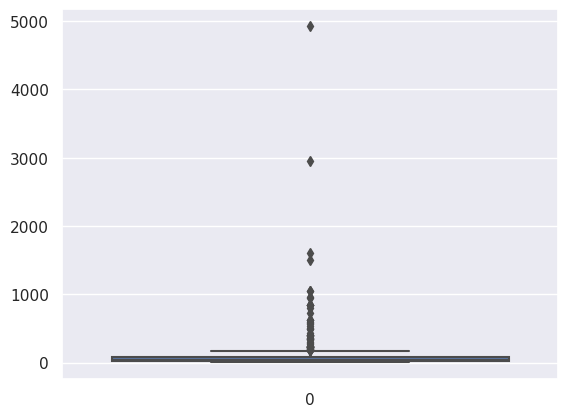

In [193]:
sns.boxplot(dados.Aspartate_Aminotransferase)

In [194]:
#Contaegem de frequência por valor
dados.Aspartate_Aminotransferase.sort_values(ascending=False).head()

135    4929
117    2946
118    1600
207    1500
199    1050
Name: Aspartate_Aminotransferase, dtype: int64

Novamente, podemos ver que não necessariamente são outliers, pois temos muitos pacientes com os valores extremos. Porém, nesta variável a diferença entre a média e o valor extremo é muito alta!  
  
Para esta variável, vamos remover os registros com os valores extremos.

In [195]:
# Manter somente os registros onde o valor for menor ou igual a 3000
dados = dados[dados.Aspartate_Aminotransferase <= 3000]
dados.shape

(569, 11)

<Axes: >

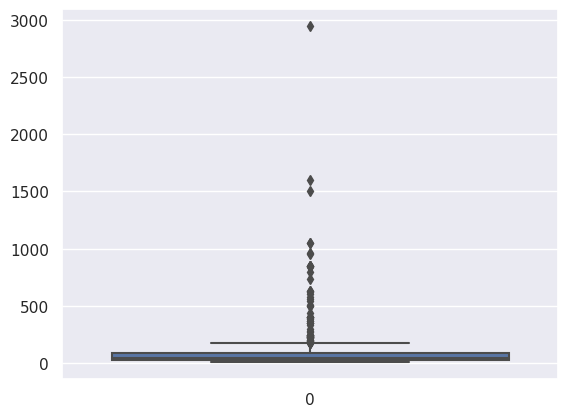

In [196]:
sns.boxplot(dados.Aspartate_Aminotransferase)

In [197]:
# Contagem de frequência por valor
dados.Aspartate_Aminotransferase.sort_index(ascending=False).head()

582    24
581    32
580    49
579    31
578    34
Name: Aspartate_Aminotransferase, dtype: int64

In [198]:
# Manter somente os registros onde o valor for menor ou igual a 2500
dados = dados[dados.Aspartate_Aminotransferase <= 2500]
dados.shape

(568, 11)

In [199]:
dados.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
count,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,564.000000,568.000000
mean,44.834507,0.246479,3.291197,1.482042,290.482394,74.286972,95.901408,6.496831,3.150000,0.948174,0.711268
std,16.237569,0.431340,6.257583,2.826056,243.271522,155.240601,171.956479,1.089500,0.797571,0.319301,0.453573
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.000000,0.800000,0.200000,175.750000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,0.000000,1.000000,0.300000,208.000000,35.000000,41.000000,6.600000,3.100000,0.950000,1.000000
75%,58.000000,0.000000,2.600000,1.300000,298.000000,60.000000,86.000000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,1680.000000,1600.000000,9.600000,5.500000,2.800000,1.000000


Veja que o valor máximo da variável Alamine_Aminotransferase também dimunui, com a remoção do último paciente.

## 3.1- Tratamento de Valores Ausentes

Verificando se há valores ausentes:

In [200]:
dados.isnull().values.any()

True

In [201]:
#Verifica quantas colunas tem valor ausente
dados.isnull().values.any().sum()

1

Apenas uma variável possui valores ausentes.

In [202]:
dados[dados.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
209,45,1,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,0,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,1,0.6,0.2,180,12,15,5.2,2.7,NaN,0
312,27,0,1.3,0.6,106,25,54,8.5,4.8,NaN,0


Como temos mais de 500 registros, vamos excluir estes registros:

In [203]:
dados = dados.dropna(how='any')

In [204]:
#Verificando se ainda há valores ausentes:

In [205]:
dados[dados.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target


## 3.2 - Pré-Processamento de Dados Para Construção de Modelos de Machine Learning.

Esta é a última etapa, antes de construir os modelos de ML!

Dada a alta correlação entre as variáveis Direct_Bilirubin e Total_Bilirubin, vamos remover Direct_Bilirubin:

In [206]:
dados = dados.drop('Direct_Bilirubin', 1)

**Divisão em Treino e Teste**

In [207]:
# Criando um objeto separado para a variável target
y = dados.Target

In [208]:
# Criando um objeto separado para as variáveis de entrada
X = dados.drop('Target', axis=1)

In [209]:
# Split em dados de treino e teste com amostragem estratificada
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=dados.Target)

In [210]:
len(X_treino)

423

In [211]:
len(X_teste)

141

**Balanceamento de Classe**

In [212]:
y_treino.value_counts()

1    301
0    122
Name: Target, dtype: int64

Podemos perceber que 301 pacientes que desenvolveram a doença hepática e 122 pacientes que não desenvolveram hepática. As classes estão desbalanceadas!  
Se levarmos os dados como estão para o treinamento dos modelos, ou seja, sem balanceamento; vamos construir um modelo tendencioso! 

Vamos aplicar a técnica de oversampling e aumentar o número de exemplos da classe minoritária:

In [213]:
import imblearn
from imblearn.over_sampling import SMOTE

# Criando dados sintéticos com base nos dados existentes
over_sampler = SMOTE(k_neighbors=2)

Vamos realizar o balanceamento de classes somente nos dados de treino, de forma que não haja interferências artificiais introduzidas pelo procedimento de balanceamento e consigamos avaliar o desempenho real do modelo (ou dos modelos)!

In [214]:
# Aplicando o oversampling
X_res, y_res = over_sampler.fit_resample(X_treino, y_treino)

In [215]:
len(X_res)

602

In [216]:
len(y_res)

602

In [217]:
y_res.value_counts()

1    301
0    301
Name: Target, dtype: int64

In [218]:
#Ajustando os nomes
X_treino = X_res

In [219]:
y_treino = y_res

**Padronização dos Dados**

Podemos perceber que os dados não estão na mesma escala. Vejamos:

In [220]:
X_treino.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,45,0,2.5,163,28,22,7.6,4.0,1.1
1,72,0,0.8,148,23,35,6.0,3.0,1.0
2,18,0,0.8,282,72,140,5.5,2.5,0.8
3,42,0,8.9,272,31,61,5.8,2.0,0.5
4,42,0,0.8,127,29,30,4.9,2.7,1.2


Na modelagem preditiva, é importante destacar que a grande maioria algoritmos de ML têm como suposição, que os dados estejam na mesma escala. Se não entregarmos dados na mesma escala para os algoritmos, qualquer avaliação do resultado (*mesmo que seja boa!*) será equivocada!  
  
Primeiro, vamos calcular a média dos dados de entrada (treino):

In [221]:
treino_mean = X_treino.mean()
treino_std = X_treino.std()
print(treino_mean)
print(treino_std)

Age                            43.506645
Gender                          0.215947
Total_Bilirubin                 2.679942
Alkaline_Phosphotase          268.257475
Alamine_Aminotransferase       63.023256
Aspartate_Aminotransferase     78.549834
Total_Protiens                  6.524488
Albumin                         3.247546
Albumin_and_Globulin_Ratio      0.998920
dtype: float64
Age                            16.266012
Gender                          0.411820
Total_Bilirubin                 5.563261
Alkaline_Phosphotase          223.923764
Alamine_Aminotransferase      139.939193
Aspartate_Aminotransferase    144.066950
Total_Protiens                  1.017616
Albumin                         0.753943
Albumin_and_Globulin_Ratio      0.306373
dtype: float64


Agora, vamos modificar os dados, sem perder a informação!  
 
Aplicando a padronização:

In [222]:
X_treino = (X_treino - treino_mean) / treino_std

In [223]:
X_treino.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,0.091808,-0.524372,-0.032345,-0.470059,-0.250275,-0.392525,1.056893,0.998026,0.329925
1,1.751711,-0.524372,-0.337921,-0.537047,-0.286005,-0.302289,-0.515409,-0.328335,0.003525
2,-1.568095,-0.524372,-0.337921,0.061371,0.064147,0.426539,-1.006753,-0.991516,-0.649274
3,-0.092625,-0.524372,1.118060,0.016713,-0.228837,-0.121817,-0.711947,-1.654696,-1.628473
4,-0.092625,-0.524372,-0.337921,-0.630828,-0.243129,-0.336995,-1.596367,-0.726244,0.656325


In [224]:
X_treino.describe()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
count,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02
mean,8.852277e-17,-4.721214e-17,2.360607e-17,-5.901518e-18,-5.901518e-18,-1.180304e-17,-1.408987e-16,3.540911e-17,-5.665457e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.428785e+00,-5.243722e-01,-4.098211e-01,-9.166400e-01,-3.789021e-01,-4.758193e-01,-3.758282e+00,-3.113693e+00,-2.281272e+00
25%,-7.074042e-01,-5.243722e-01,-3.395032e-01,-4.298672e-01,-2.860046e-01,-3.786422e-01,-6.590940e-01,-6.164882e-01,-6.492738e-01
50%,9.180833e-02,-5.243722e-01,-3.160793e-01,-3.115233e-01,-2.216910e-01,-2.849358e-01,7.420437e-02,-3.451790e-03,3.525391e-03
75%,7.065872e-01,-5.243722e-01,-1.401951e-01,6.137144e-02,-7.162579e-02,-7.322869e-02,6.638177e-01,8.180963e-01,6.133073e-01
max,2.858313e+00,1.903874e+00,1.299958e+01,8.224864e+00,1.155485e+01,1.056072e+01,3.022271e+00,2.987567e+00,5.878718e+00


Agora, precisamos padronizar os dados de teste com a média e desvio padrão do treino, ou seja: com o mesmo "padrão" adotado nos dados de treino!  
  
A justificativa deste último procedimento, é simples: foi assim, que o algortimo aprendeu, logo quando usarmos o modelo com novos dados, deveremos padronizar esses dados (seguindo o mesmo padrão que foi usado nos dados do treino).

**Toda e qualquer transformação aplicada em treino, deve ser aplicada em teste e em novos dados!**

In [225]:
X_teste = (X_teste - treino_mean) / treino_std

In [226]:
X_teste.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
220,-0.400015,-0.524372,-0.337921,-0.541512,-0.257421,-0.225935,-1.498098,-0.991516,0.003525
448,0.276242,1.903874,-0.337921,-0.563841,-0.264567,-0.371701,-0.515409,-0.858880,-0.975673
509,0.153286,-0.524372,3.113293,-0.063671,0.550073,3.203026,-1.105022,-0.328335,0.656325
415,1.628755,-0.524372,-0.248045,1.883420,0.214213,-0.267583,-2.873862,-0.726244,-0.975673
56,-0.645926,-0.524372,-0.337921,-0.313756,-0.264567,-0.385583,1.449969,0.998026,0.003525


## **Construção, Treinamento e Avaliação do Modelo 1 com Regressão Logística (Benchmark)**

Na primeira versão do modelo, o ideal é utilizar um algortmo simples, que será usado como Benchmark (modelo base). Vamos utilizar a regressão logística.

In [227]:
# Definindo lista de hiperparâmetros
tuned_params_v1 = {'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000],
                    'penalty': ['l1', 'l2']}

In [228]:
# Criando modelo com GridSearch
# Vários modelos serão criados com diferentes combinações de hiperparâmetros

modelo_v1 = GridSearchCV(LogisticRegression(),
                        tuned_params_v1,
                        scoring = 'roc_auc',
                        n_jobs = -1)

In [229]:
# Treinamento do modelo
modelo_v1.fit(X_treino, y_treino)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [230]:
# melhor modelo
modelo_v1.best_estimator_

LogisticRegression(C=1)

In [231]:
# Previsões com dados de teste
y_pred_v1 = modelo_v1.predict(X_teste)

In [232]:
# Mostrando as 10 primeiras previsões
y_pred_v1[:10]

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1])

In [233]:
# Previsões no formato de probabilidade para cada classe
y_pred_proba_v1 = modelo_v1.predict_proba(X_teste)

In [234]:
# Mostrando as 10 primeiras previsões
np.set_printoptions(formatter={'float': '{:0.8f}'.format}) # Configurar a formatação para exibição dos arrays 

y_pred_proba_v1[:10]


array([[0.75057001, 0.24942999],
       [0.49299936, 0.50700064],
       [0.00024964, 0.99975036],
       [0.68179639, 0.31820361],
       [0.66217821, 0.33782179],
       [0.60734405, 0.39265595],
       [0.74298551, 0.25701449],
       [0.08620232, 0.91379768],
       [0.59058794, 0.40941206],
       [0.01234522, 0.98765478]])

Explicando os resultados acima:

* Para o primeiro resultado (*cuja classe é 0*), na prática a regressão logística tem aproximadamente 75% de certeza que é classe 0 25% de certeza de que é classe 1. Como a probabilidade maior é da classe 0, ela previu com classe 0. Segue a mesma lógica para todas as linhas.

* Além de prever a classe, a regressão logística também possibilita prever a probabilidade daquela classe, o que é muito últil na área médica - *que é o caso desse projeto*!

Vamos extrair a probabilidade somente da classe 1 (**desenvolveram doença hepática**), para calcular a curva ROC:

In [235]:
y_pred_proba_v1 = modelo_v1.predict_proba(X_teste)[:,1]

In [236]:
# Mostrando as 10 primeiras previsões
y_pred_proba_v1[:10]

array([0.24942999, 0.50700064, 0.99975036, 0.31820361, 0.33782179,
       0.39265595, 0.25701449, 0.91379768, 0.40941206, 0.98765478])

Como exemplo, vamos verificar um dos pontos de dados:

In [237]:
i = 98
print('Para o ponto de dado {}, classe real = {}, classe prevista = {}, probabilidade prevista = {}'.format(i, y_teste.iloc[i], y_pred_v1[i], y_pred_proba_v1[i]))

Para o ponto de dado 98, classe real = 1, classe prevista = 1, probabilidade prevista = 0.9089084752473486


In [238]:
confusion_matrix(y_teste, y_pred_v1)

array([[32,  8],
       [38, 63]])

In [239]:
# Extraindo cada valor da CM
tn, fp, fn, tp = confusion_matrix(y_teste, y_pred_v1).ravel()
print(tn, fp, fn, tp)

32 8 38 63


Calculando a métrica global AUC (Area Under The Curve) com dados reais e previsões em teste (quanto maior, melhor!):

In [240]:
roc_auc_v1 = roc_auc_score(y_teste, y_pred_v1)
print(roc_auc_v1)

0.7118811881188121


Calculando a curva ROC com dados e previsões em teste:

In [241]:
fpr_v1 , tpr_v1, thresholds = roc_curve(y_teste, y_pred_proba_v1)

AUC em teste:

In [242]:
auc_v1 = auc(fpr_v1, tpr_v1)
print(auc_v1)

0.7368811881188119


Acurácia em teste:

In [243]:
acuracia_v1 = accuracy_score(y_teste, y_pred_v1 )
print(acuracia_v1)

0.6737588652482269


Ou seja: o nosso modelo base, em cada 100 previsões, acerta 64.

**Feature Importance**

Construindo novamente o modelo com os melhores hiperparâmetro (não precisamos mais do GrideSearchVC, pois já sabemos qual é o melhor parâmetro).

In [244]:
modelo_v1 = LogisticRegression(C = 1)
modelo_v1.fit(X_treino, y_treino)

LogisticRegression(C=1)

Obtemos os coeficientes ordernados pelo maior, usando np.argsort:

In [245]:
indices = np.argsort(-abs(modelo_v1.coef_[0,:]))

In [246]:
print("Variáveis mais importantes para o resultado do modelo_v1:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

Variáveis mais importantes para o resultado do modelo_v1:
--------------------------------------------------
Total_Bilirubin
Alamine_Aminotransferase
Aspartate_Aminotransferase
Albumin
Total_Protiens
Age
Alkaline_Phosphotase
Gender
Albumin_and_Globulin_Ratio


**Salvando o modelo em disco:**

In [247]:
with open('modelos/modelo_v1.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v1, 'modelos/modelo_v1.pkl') 

Criando um dataframe para receber as métricas de cada modelo:

In [248]:

df_modelos = pd.DataFrame()

Dicionário com as métricas do modelo_v1:

In [249]:

dict_modelo_v1 = {'Nome': 'modelo_v1', 
                  'Algoritmo': 'Regressão Logística', 
                  'ROC_AUC Score': roc_auc_v1,
                  'AUC Score': auc_v1,
                  'Acurácia': acuracia_v1}

Adicionando o dict ao dataframe:

In [250]:
df_modelos = df_modelos.append(dict_modelo_v1, ignore_index = True)

In [251]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.711881,0.736881,0.673759


## **Construção, Treinamento e Avaliação do Modelo 2 com Random Forest**

O objetivo deste próximo passo, é tentar obter um modelo melhor que primeira versão. Vamos testar com Random Forest:

In [252]:
# Grid de hiperparâmetros
tuned_params_v2 = {'n_estimators' : [100, 200, 300, 400, 500],
                   'min_samples_split' : [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

In [253]:
# Criando modelo com RandomizedSearchCV para buscar a melhor combinação de hiperparâmetros
modelo_v2 = RandomizedSearchCV(RandomForestClassifier(),
                               tuned_params_v2,
                               n_iter=15,
                               scoring='roc_auc',
                               n_jobs=-1)

In [254]:
#Trinando o modelo:
modelo_v2.fit(X_treino, y_treino)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='roc_auc')

In [255]:
#Extraindo o melhor modelo
modelo_v2.best_estimator_

RandomForestClassifier(n_estimators=500)

Obtemos que o melhor modelo, foi com 400 árvores.

In [256]:
#Previsões em teste
y_pred_v2 = modelo_v2.predict(X_teste)

In [257]:
#Obtendo as previsões para a classe positiva
y_pred_proba_v2 = modelo_v2.predict_proba(X_teste)[:,1]

In [258]:
confusion_matrix(y_teste, y_pred_v2)

array([[18, 22],
       [16, 85]])

In [259]:
# Curva ROC nos dados e previsões em teste
roc_auc_v2 = roc_auc_score(y_teste, y_pred_v2)
print(roc_auc_v2)

0.6457920792079207


In [260]:
# Curva ROC nos dados e previsões em teste
fpr_v2, tpr_v2, thresholds = roc_curve(y_teste, y_pred_proba_v2)

In [261]:
# AUC em teste
auc_v2 = auc(fpr_v2, tpr_v2)
print(auc_v2)

0.7503712871287129


In [262]:
#Acurácia em teste
acuracia_v2 = accuracy_score(y_teste, y_pred_v2)
print(acuracia_v2)

0.7304964539007093


**Feature Importance**

In [263]:
modelo_v2.best_params_

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1}

In [264]:
# Recriando o modelo com os melhores hiperparâmetros
modelo_v2 = RandomForestClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=1)
modelo_v2.fit(X_treino, y_treino)

RandomForestClassifier(n_estimators=400)

In [265]:
# Variáveis mais relevantes
indices = np.argsort(-modelo_v2.feature_importances_)
print("Variáveis mais importantes para o resultado do modelo_v2: ")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

Variáveis mais importantes para o resultado do modelo_v2: 
--------------------------------------------------
Total_Bilirubin
Alkaline_Phosphotase
Aspartate_Aminotransferase
Alamine_Aminotransferase
Albumin_and_Globulin_Ratio
Age
Total_Protiens
Albumin
Gender


Total_Bilirubin aparece novamente no topo da lista, o que pode ser um bom sinal, no sentido que os dois modelos até o momento estão encontrando os mesmos insights. Em outras palavras: há um padrão nos dados!

In [266]:
#Salvando o modelo em disco
with open('modelos/modelo_v2.pkl', 'wb') as pickle_file:
    joblib.dump(modelo_v2, 'modelos/modelo_v2.pkl')

In [267]:
# Dicionário com as métricas do modelo_v2
dict_modelo_v2 = {'Nome' : 'modelo_v2',
                  'Algoritmo' : 'Random Forest',
                  'ROC_AUC Score' : roc_auc_v2,
                  'AUC Score' : auc_v2,
                  'Acurácia' : acuracia_v2}

In [268]:
# Adicionando o dict ao dataframe
df_modelos = df_modelos.append(dict_modelo_v2, ignore_index=True)

In [269]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.711881,0.736881,0.673759
1,modelo_v2,Random Forest,0.645792,0.750371,0.730496


## **Construção, Treinamento e Avaliação do Modelo 3 com KNN**

Testando o algoritmo KNN, para criar a versão 3 do modelo.  
  
Lista de possíveis valores de K:

In [270]:
vizinhos = list(range(1, 20, 2))

In [271]:
# Lista para os scores
cv_scores = []

In [272]:
# Validação cruzada para determinada o melhor valor de k
for k in vizinhos:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_treino, y_treino, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

In [273]:
#Ajustando o erro de classificação
erro = [1 - x for x in cv_scores]

In [274]:
# Determinando o melhor valor de k (com menor erro)
optimal_k = vizinhos[erro.index(min(erro))]
print('O valor ideal de k é %d' % optimal_k)

O valor ideal de k é 1


In [275]:
# Criando o modelo versão 3
modelo_v3 = KNeighborsClassifier(n_neighbors=optimal_k)

In [276]:
# Treinamento
modelo_v3.fit(X_treino, y_treino)

KNeighborsClassifier(n_neighbors=1)

In [277]:
# Previsões
y_pred_v3 = modelo_v3.predict(X_teste)

In [278]:
confusion_matrix(y_teste, y_pred_v3)

array([[18, 22],
       [40, 61]])

In [279]:
# Previsão de probabilidade da classe positiva
y_pred_proba_v3 = modelo_v3.predict_proba(X_teste)[:,1]

In [280]:
# Calculando ROC_AUC em teste
roc_auc_v3 = roc_auc_score(y_teste, y_pred_v3)
print(roc_auc_v3)

0.526980198019802


In [281]:
# Calculando curva ROC
fpr_v3, tpr_v3, thresholds = roc_curve(y_teste, y_pred_proba_v3)

In [282]:
#Calculando AUC em teste
auc_v3 = auc(fpr_v3, tpr_v3)
print(auc_v3)

0.526980198019802


In [283]:
# Calculando acurácia
acuracia_v3 = accuracy_score(y_teste, y_pred_v3)
print(acuracia_v3)

0.5602836879432624


Com o algoritmo KNN, não extraímos as variáveis mais importantes, pois o conceito do algoritmo é diferente.

In [284]:
#Salvando o modelo em disco
with open('modelos/modelo_v3.pkl', 'wb') as pickle_file:
    joblib.dump(modelo_v3, 'modelos/modelo_v3.pkl')

In [285]:
# Dicionário com as métricas do modelo_v3:
dict_modelo_v3 = {'Nome' : 'modelo_v3',
                  'Algoritmo' : 'KNN',
                  'ROC_AUC Score' : roc_auc_v3,
                  'AUC Score' : auc_v3,
                  'Acurácia' : acuracia_v3}

In [286]:
# Adiciona o dict ao dataframe
df_modelos = df_modelos.append(dict_modelo_v3, ignore_index=True)

In [287]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.711881,0.736881,0.673759
1,modelo_v2,Random Forest,0.645792,0.750371,0.730496
2,modelo_v3,KNN,0.526980,0.526980,0.560284


## **Construçãom, Treinamento e Avaliação do Modelo 4 com Decision Tree**

Na versão 4, vamos usar o modelo de árvore de decisão.

Já utilizamos o Random Forest como nosso segundo modelo, onde tivemos o resultado do treinamento de 400 árvores de decisão. Vamos testar simplificar utilizando apenas uma árvore de decisão, pois é um modelo menos sucestível à problemas nos dados.

In [288]:
# hiperparâmetros
tuned_params_v4 = {'min_samples_split' : [2, 3, 4, 5, 7],
                   'min_samples_leaf': [1, 2, 3, 4, 6],
                   'max_depth' : [2, 3 , 4, 5, 6, 7]}

In [289]:
# Criando o modelo com RandomizedSearchCV
modelo_v4 = RandomizedSearchCV(DecisionTreeClassifier(),
                               tuned_params_v4,
                               n_iter=15,
                               scoring='roc_auc',
                               n_jobs=-1)

In [290]:
# Treinamento
modelo_v4.fit(X_treino, y_treino)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 6],
                                        'min_samples_split': [2, 3, 4, 5, 7]},
                   scoring='roc_auc')

In [291]:
# Melhor modelo
modelo_v4.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=5)

In [292]:
# Previsões de classe
y_pred_v4 = modelo_v4.predict(X_teste)

In [293]:
# Previsões de probabilidade
y_pred_proba_v4 = modelo_v4.predict_proba(X_teste)[:,1]

In [294]:
confusion_matrix(y_teste, y_pred_v4)

array([[24, 16],
       [38, 63]])

In [295]:
# Calculando ROC AUC score
roc_auc_v4 = roc_auc_score(y_teste, y_pred_v4)
print(roc_auc_v4)

0.6118811881188119


In [296]:
# Curva ROC
fpr_v4, tpr_v4, thresholds = roc_curve(y_teste, y_pred_v4)

In [297]:
# AUC
auc_v4 = auc(fpr_v4, tpr_v4)
print(auc_v4)

0.6118811881188119


In [298]:
# Calculando acurácia
acuracia_v4 = accuracy_score(y_teste, y_pred_v4)
print(acuracia_v4)

0.6170212765957447


**Feature Importance**

In [299]:
modelo_v4.best_params_

{'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 7}

In [300]:
#Recriando o modelo
modelo_v4 = DecisionTreeClassifier(min_samples_split=4, min_samples_leaf=6, max_depth=5)
modelo_v4.fit(X_treino, y_treino)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=6, min_samples_split=4)

In [301]:
# Variáveis mais importantes
indices = np.argsort(-modelo_v4.feature_importances_)
print("Variáveis mais importantes para o restulado do modelo_v4:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

Variáveis mais importantes para o restulado do modelo_v4:
--------------------------------------------------
Total_Bilirubin
Aspartate_Aminotransferase
Alkaline_Phosphotase
Age
Albumin
Alamine_Aminotransferase
Total_Protiens
Albumin_and_Globulin_Ratio
Gender


Mais uma vez, temos Total_Bilirubin está como a variávei mais importante para predição!

In [302]:
# Salvando o modelo em disco
with open('modelos/modelo_v4.pkl', 'wb') as pickle_file:
    joblib.dump(modelo_v4, 'modelos/modelo_v4.pkl')

In [303]:
# Dicionário com as métricas do modelo_v4
dict_modelo_v4 = {'Nome' : 'modelo_v4',
                  'Algoritmo' : 'Decision Tree',
                  'ROC_AUC Score' : roc_auc_v4,
                  'AUC Score' : auc_v4,
                  'Acurácia' : acuracia_v4}

In [304]:
#Adicionando o dict no dataframe dos modelos
df_modelos = df_modelos.append(dict_modelo_v4, ignore_index=True)
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.711881,0.736881,0.673759
1,modelo_v2,Random Forest,0.645792,0.750371,0.730496
2,modelo_v3,KNN,0.526980,0.526980,0.560284
3,modelo_v4,Decision Tree,0.611881,0.611881,0.617021


## **Construção, Treinamento e Avaliação do Modelo 5 com SVM**

Vamos testar o algoritmo SVM como nossa 5 versão do modelo.

In [305]:
# Função para seleção de hiperparâmetros
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C' : Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv = nfolds)
    grid_search.fit(X_treino, y_treino)
    grid_search.best_params_
    return grid_search.best_params_

In [306]:
# Aplicando a função que acabamos de criar
svc_param_selection(X_treino, y_treino, 5)

{'C': 10, 'gamma': 1}

In [307]:
# Criando o modelo com os melhores hiperparâmetros
modelo_v5 = SVC(C = 1, gamma = 1, probability=True)

In [308]:
#Treinamento
modelo_v5.fit(X_treino, y_treino)

SVC(C=1, gamma=1, probability=True)

In [309]:
# Previsões de classe
y_pred_v5 = modelo_v5.predict(X_teste)


In [310]:
confusion_matrix(y_teste, y_pred_v5)

array([[17, 23],
       [27, 74]])

In [311]:
# Previsões de probabilidade
y_pred_proba_v5 = modelo_v5.predict_proba(X_teste)[:,1]

In [312]:
# Calculando ROC AUC score
roc_auc_v5 = roc_auc_score(y_teste, y_pred_v5)
print(roc_auc_v5)

0.5788366336633664


In [313]:
# Calculando curva ROC
fpr_v5, tpr_v5, thresholds = roc_curve(y_teste, y_pred_proba_v5)

In [314]:
# Calculando AUC score
auc_v5 = auc(fpr_v5, tpr_v5)
print(auc_v5)

0.6202970297029703


*O SVM também não tem o parâmetro de importância das variáveis para analisarmos.*

In [315]:
# Calculando a acurárcia
acuracia_v5 = accuracy_score(y_teste, y_pred_v5)
print(acuracia_v5)

0.6453900709219859


In [316]:
# Salvando o modelo em disco
with open('modelos/modelo_v5.pkl', 'wb') as pickle_file:
    joblib.dump(modelo_v5, 'modelos/modelo_v5.pkl')

In [317]:
# Dicionário com as métricas do modelo_v5
dict_modelo_v5 = {'Nome' : 'modelo_v5',
                  'Algoritmo' : 'SVM',
                  'ROC_AUC Score' : roc_auc_v5,
                  'AUC Score' : auc_v5,
                  'Acurácia' : acuracia_v5}

In [318]:
# Adicionando o dict ao dataframe df_modelos
df_modelos = df_modelos.append(dict_modelo_v5, ignore_index=True)
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.711881,0.736881,0.673759
1,modelo_v2,Random Forest,0.645792,0.750371,0.730496
2,modelo_v3,KNN,0.526980,0.526980,0.560284
3,modelo_v4,Decision Tree,0.611881,0.611881,0.617021
4,modelo_v5,SVM,0.578837,0.620297,0.645390


## **Selecionando o Melhor Modelo**

Como testamos algoritmos diferentes, faz sentido optar como critário para selecionar o melhor modelo, a métrica AUC Score (ideal neste cenário).

In [319]:
# Obtendo o nome do melhor modelo
df_melhor_modelo = df_modelos[df_modelos['AUC Score'] == df_modelos['AUC Score'].max()]
df_melhor_modelo

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
1,modelo_v2,Random Forest,0.645792,0.750371,0.730496


## **Previsões com o Melhor Modelo Treinado**

Automatizando a tarefa de obter o nome do modelo e carregá-lo a partir do diretório salvo:

In [320]:
modelo = df_melhor_modelo.Nome.to_string(index=False)

melhor_modelo = joblib.load('modelos/' + modelo + '.pkl')
melhor_modelo

RandomForestClassifier(n_estimators=400)

In [321]:
dados.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Target'],
      dtype='object')

In [322]:
#Dados brutos de um novo paciente (o número de colunas deve ser o mesmo do que foi utilizado em treino)
novo_paciente = [72, 1, 0.8, 186, 15, 29, 7.1, 3.4, 0.97]

In [323]:
# Convertendo o objeto para array
arr_paciente = np.array(novo_paciente)

In [324]:
# Usamos média e desvio de treino para padronizar novos dados
arr_paciente = (arr_paciente - treino_mean) / treino_std

In [325]:
# Convertendo o objeto para array
arr_paciente = np.array(arr_paciente)

arr_paciente

array([1.75171119, 1.90387448, -0.33792083, -0.36734589, -0.34317231,
       -0.34393616, 0.56554881, 0.20220905, -0.09439449])

In [326]:
# Convertendo o shape do array numpy e realiando a previsão:
pred_novo_paciente = melhor_modelo.predict(arr_paciente.reshape(1, -1))

In [328]:
# Verificando o valor e imprimindo o resultado final:

if pred_novo_paciente == 1:
    print('Este paciente deve apresentar doença hepática!')
else:
    print('Este paciente não deve apresentar doença hepática!')

Este paciente não deve apresentar doença hepática!
